# No-Framework Linear Regression

### This implementation uses only Numpy to build a linear regression model

### Goal: Predict used car prices using gradient descent optimization

What we'll implement manually:
- Train/Test split
- Feature scaling (z-score normalization)
- Forward pass (predictions)
- Cost function (Mean Squared Error)
- Gradient computation
- Parameter updates (gradient descent)
- Evaluation metrics (MSE, RMSE, R^2)

In [1]:
# Numpy: Core library for numerical operations on arrays
# ONLY external dependency for the model itself
import numpy as np

# matplotlib: for creating visualizations of training progress and results
import matplotlib.pyplot as plt

# os: for handling file paths in a cross-platform way
import os

# Set random seed for reporducibility
# Project-wide seed of 113
np.random.seed(113)

# time: Built-in module for measuring execution time
import time

# tracemalloc: Built-in module for tracking memory allocation
import tracemalloc

# platform: Built-in module for system information
import platform


# Load cleaned data

- Load the pre-processed dataset that was cleaned in the data-preperation step
- This same file will be used by all 4 frameworks for fair comparison

In [2]:
# Define path to our cleaned dataset
DATA_PATH = os.path.join('..', '..', 'data', 'processed', 'vehicles_clean.csv')

# np.genfromtxt() reads CSV files into numpy arrays
# delimiter=',' specifies that columns are seperated by comas
# skip_header=1 skips the first row (column names)
# Gives us a 2D array where each row is a car, each column is a feature
data = np.genfromtxt(DATA_PATH, delimiter=',', skip_header=1)

# Verify the data loaded correctly
# shape should be (100000, 12)
print(f"Data shape: {data.shape}")
print(f"First row: {data[0]}")

Data shape: (100000, 12)
First row: [2.9990e+04 2.0140e+03 7.0000e+00 2.0000e+00 6.0000e+00 2.0000e+00
 2.6129e+04 0.0000e+00 2.0000e+00 0.0000e+00 8.0000e+00 1.7000e+01]


# Seperate features and Target
- Our columns are: price, year, manufacturer, condition, cylinders, fuel, odometer, title_status, transmission, drive, type, state
- price (column 0) is our TARGET - what we want to predict
- All other columns (1-11) are FEATURES - inputs to our model

In [3]:
# Extract target variable (price)
# data[:, 0] means "all rows, column 0"
y = data[:, 0]

# Extract features variables
# data[:, 1:] means "all rows, column 1 through the end"
X = data[:, 1:]

# Print shapes to verify seperation
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

Features (X) shape: (100000, 11)
Target (y) shape: (100000,)


In [4]:
# Define feature names for reference (matching our cleaned data columns)
FEATURE_NAMES = ['year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'state']
print(f"Feature Names: {FEATURE_NAMES}")

Feature Names: ['year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'state']


# Train/Test Split

We need to split our data into two sets:
- Training set (80%): Used to train the model (learn the weights)
- Trest set (20%): Used to evaluate performance on unseen data

Why Split? If we test on the same data we traine don, we can't tell if the model actually learned patterns or just memorized the training data.

In [5]:
def train_test_split(X, y, test_size=0.2, random_seed=113):
    """
    Split features and target into training and testing sets.

    Parameters:
    -----------
    X : numpy.ndarray
        Feature matrix of shape (n_samples, n_features)

    y : numpy.ndarray
        Target vector of shape (n_samples,)
    
    test_size : float
        Proportion of data to use for testing (0.0 to 1.0)
        Default 0.2 means 20% test, 80% train
    
    random_seed : int
        Seed for random number generator to ensure reproducibility

    Returns:
    --------
    X_train, X_test, y_train, y_test : numpy.ndarray
        Split arrays for training and testing
    """

    # Set random seed for reproducibility
    np.random.seed(random_seed)

    # Get the total number of samples in our dataset
    n_samples = X.shape[0]

    # Calculate the number of test samples
    # int() truncates to whole number
    n_test = int(n_samples * test_size)

    # Calculate number of training samples
    n_train = n_samples - n_test

    # Create an array of all indices
    indices = np.arange(n_samples)

    # Randomly shuffle the indices
    # np.random.shuffle() modifies the array in place
    # This randomizes which samples go to train vs test
    np.random.shuffle(indices)

    # Split indices into train and test portions
    # First n_train indices go to training set
    train_indices = indices[:n_train]
    # Remaining indices go to test set
    test_indices = indices[n_train:]

    # Use the indices to select rows from X and y
    # X[train_indices] selects rows at those index positions
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test


# Perform the split using our funciton
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_seed=113)

# Verify the split worked correctly
print(f"Training set size: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Test set size: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.0f}%)")
print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Training set size: 80,000 samples (80%)
Test set size: 20,000 samples (20%)

X_train shape: (80000, 11)
X_test shape: (20000, 11)
y_train shape: (80000,)
y_test shape: (20000,)


# Feature Scaling (Z-score normalization)

Feature scaling is critical for gradient descent to work properly.

Why scale features?
Our features have very different ranges:
- year: 1990-2022 (range of 32)
- odometer: 100-500,000 (range of 500,000)
- manufacturer: 0-40 (range of 40)

Without scaling, features with large values dominate the gradients, causing gradient descent to zigzag inefficently or fail to converge.

Z-score normalization transforms each feature to have
- Mean = 0
- Standard deviation = 1
Formula: x_scaled = (x - mean) / std

IMPORTANT: We calculate mean and std from TRAINING data only!
Using test data statistics would be "data leakage" - the model would indirectly learn information about the test set during training.

In [6]:
def compute_scaling_params(X_train):
    """
    Compute mean and standard deviation for each feature from training data.

    Parameters:
    -----------
    X_train : numpy.ndarray
        Training feature matrix of shape (n_samples, n_features)

    Returns:
    --------
    means: numpy.ndarray
        Mean of each feature, shape (n_features,)
    stds : numpy.ndarray
        Standard deviation of each feature, shape (n_features,)
    """
    # np.mean() with axis=0 computes mean for each column (feature)
    # Results in a 1D array with one mean value per feature
    means = np.mean(X_train, axis=0)

    # np.std() with axis=0 computes standard deviation for each column
    # Result is a 1D array with one std value per feature
    stds = np.std(X_train, axis=0)

    return means, stds

def scale_features(X, means, stds):
    """
    Apply z-score normalization to features.

    Parameters:
    -----------
    X : numpy.ndarray
        Feature matrix to scale, shape (n_samples, n_features)
    means : numpy.ndarray
        Mean of each feature (from training data)
    stds : numpy.ndarray
        Standard deviation of each feature (from training data)

    Returns:
    --------
    X_scaled : numpy.ndarray
        Noramlized feature matrix with mean=0, std=1 for each feature
    """
    # Apply z-score formula: (X - mean) / stds
    # Numpy broadcasting handles the element-wise operations automatically
    # Each column is subtracted by its mean, then divided by its std
    X_scaled = (X - means) / stds

    return X_scaled

# Step 1: Compute scaling parameters from TRAINING data only
means, stds = compute_scaling_params(X_train)

# Display the computed parameters for each feature
print("Scaling parameters (computed from training data:)\n")
print(f"{'Feature':<15} {'Mean':>15} {'Std':.15}")
print("-" *47)
for i, name in enumerate(FEATURE_NAMES):
    print(f"{name:<15} {means[i]:>15.2f} {stds[i]:>15.2f}")

# Step 2: Apply scaling to both training and test data
# IMPORTANT: Use the same means and stds (from training) for both sets
X_train_scaled = scale_features(X_train, means, stds)
X_test_scaled = scale_features(X_test, means, stds)

# Verify scaling worked - training data should have mean=0 and std=1
print("\n--- Verification (Training Data After Scaling) ---")
print(f"Mean of each feature (should be =0): {np.mean(X_train_scaled, axis=0).round(6)}")
print(f"Std of each feature (should be 1): {np.std(X_train_scaled, axis=0).round(6)}")


Scaling parameters (computed from training data:)

Feature                    Mean Std
-----------------------------------------------
year                    2012.32            5.78
manufacturer              18.20           11.47
condition                  3.09            2.44
cylinders                  6.00            1.92
fuel                       2.05            0.78
odometer               94285.02        63064.30
title_status               0.24            1.06
transmission               0.39            0.77
drive                      1.41            1.21
type                       7.15            4.12
state                     23.64           15.10

--- Verification (Training Data After Scaling) ---
Mean of each feature (should be =0): [-0. -0. -0. -0.  0.  0.  0. -0. -0. -0.  0.]
Std of each feature (should be 1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Initialize model parameters

Linear regression model: y_pred = X @ weights + bias

We need to learn two things:
- weights (w): One weight per feature - how much each feature affects price
- bias (b): A constant offset (the predicted price when all features are 0)

We initialize weights to zeros. This is a common starting point for linear regression. The gradient descent algorithm will adjust them.

In [7]:
# Get the number of features from our training data
n_features = X_train_scaled.shape[1]

# Initial weights as a 1D array of zeros, one weight per feature
# Shape: (11), for the 11 features
weights = np.zeros(n_features)

# Initial bias as a single scaler value of 0
bias = 0.0

print(f"Number of features: {n_features}")
print(f"Initial weights shape: {weights.shape}")
print(f"Initial weights: {weights}")
print(f"Initial bias: {bias}")

Number of features: 11
Initial weights shape: (11,)
Initial weights: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Initial bias: 0.0


# Hyperparameters

Hyperparameters are settings we choose before training (not learned)
These control how the learning process works

Learning rate (alpha): Controls how big each gradient descent step is
- Too large: May overshoot the minimum and diverge
- Too small: training will be very slow
- 0.01 is a common starting point

In [8]:
# Learning rate
learning_rate = 0.01

# Number of iterations: How many times we update the weights
# - More iterations = more chances to improve (but slower training)
# - We'll start with 1000 and adjust if needed
n_iterations = 1000

print(f"\nHyperparameters:")
print(f"    Learning rate: {learning_rate}")
print(f"    Iterations: {n_iterations}")


Hyperparameters:
    Learning rate: 0.01
    Iterations: 1000


# Forward pass (prediction function)

The forward pass computes predictions given inputs and current parameters
Linear regression formula: y_pred = X @ weights + bias

X @ weights is matrix multiplication:
- X has shape (n_samples, n_features)
- weights has shape (n_features)
- Result has shape (n_samples,)
Each sample's prediction is the weighted sum of its features plus bias

In [9]:
def forward(X, weights, bias):
    """
    Compute predictions using Linear regression formula.

    Parameters:
    -----------
    X : numpy.ndarray
        Feature matrix of shape (n_samples, n_features)
    weights : numpy.ndarray
        Weight vector of shape (n_features,)
    bias : float
        Bias term (scaler)
    
    Returns:
    --------
    y_pred : numpy.ndarray
        Predicted value of shape (n_samples,)
    """
    # @ is matrix multiplication operation in Python/Numpy
    # X @ weights computes: sum of (features_i * weight_i) for each sample
    # Adding bias shifts all predictions by a constant amount
    y_pred = X @ weights + bias

    return y_pred

# Test the forward pass with our initial (zero) weights
# With zero weights and zero bias, all predictions should be 0
y_pred_initial = forward(X_train_scaled, weights, bias)

print(f"\nForward pass test (with zero weights):")
print(f"    Prediction shape: {y_pred_initial.shape}")
print(f"    First 5 predictions: {y_pred_initial[:5]}")
print(f"    (All zeros expected since weights are zero)")


Forward pass test (with zero weights):
    Prediction shape: (80000,)
    First 5 predictions: [0. 0. 0. 0. 0.]
    (All zeros expected since weights are zero)


# Cost function (Mean Squared Error)

The cost function measures how wrong our predictions are.
We use mean squared error (MSE) - the average of squared differences.

Formula: MSE = (1/2n) * Σ(y_pred - y)²

Why squared?
- Makes all errors positive (no canceling out)
- Penalizes large errors more than small errors

Why divide by 2n instead of n?
- The 2 is a convenience for gradient calculation
- When we take the derivative, the 2 cancels out with the exponent
- This is a common convention in ML (doesn't change the optimal weights)

In [10]:
def compute_cost(y_pred, y_true):
    """
    Compute Mean Squared Error cost.

    Parameters:
    -----------
    y_pred : numpy.ndarray
        Predicted values of shapes (n_samples,)
    y_true : numpy.ndarray
        Actual values of shape (n_samples,)

    Returns:
    --------
    cost : float
        The mean squared error (scalar value)
    """
    # Get the number of samples
    n_samples = len(y_true)

    # Calculate the error (difference between prediction and actual)
    # This is a vector of errors, one per sample
    errors = y_pred - y_true

    # Square each error, sum them all, then average
    cost = np.sum(errors ** 2) / (2 * n_samples)

    return cost

print(compute_cost.__doc__)


    Compute Mean Squared Error cost.

    Parameters:
    -----------
    y_pred : numpy.ndarray
        Predicted values of shapes (n_samples,)
    y_true : numpy.ndarray
        Actual values of shape (n_samples,)

    Returns:
    --------
    cost : float
        The mean squared error (scalar value)
    


# Gradient Computation

Gradients tell us how to adjust weights and bias to reduce the cost.

The gradient is the partial derivative of the cost with respect to each paramter.
It points in the direction of steepest INCREASE, so we subtract it to decrease cost.

Intuition:
- If predictions are too high (y_pred > y), gradients are positive
- Subtracting positive gradients decreaese weights, lowering predictions
- If predictions are too low (y_pred < y), gradients are negaative
- Subtracting negative gradients increases weights, raising predictions

In [11]:
def compute_gradients(X, y_pred, y_true):
    """
    Compute gradients of the cost with respect to weights and bias.

    Parameters:
    -----------
    X : numpy.ndarray
        Feature matrix of shape (n_samples, n_features)
    y_pred : numpy.ndarray
        Predicted values of shape (n_samples,)
    y_true : numpy.ndarray
        Actual values of shape (n_samples,)

    Returns:
    --------
    dW : numpy.ndarray
        Gradient with respect to weights, shape (n_features,)
    db : float
        Gradient with respect to bias (scaler)
    """
    # Get the number of samples
    n_samples = len(y_true)

    # Calculate errors (predictions minus actual values)
    errors = y_pred - y_true

    # Gradient for weights : dW = (1/n) * X.T @ errors
    # X.T has shape (n_features, n_samples)
    # errors has shape (n_samples,)
    # X.T @ errors has shape (n_features,) - one gradient per weight
    dW = (1 / n_samples) * (X.T @ errors)

    # Gradient for bias: db = (1/n) * sum(errors)
    # This is just the average error (scaler value)
    db = (1 / n_samples) * np.sum(errors)

    return dW, db

# Test the cost function with our initial predictions
# With zero weights, all predictions are 0
initial_cost = compute_cost(y_pred_initial, y_train)

print(f"Initial cost (with zero weights): {initial_cost:.2f}")
print(f"This is high because we're predicting $0 for every car!")

# Test the gradient computation
dW_initial, db_initial = compute_gradients(X_train_scaled, y_pred_initial, y_train)

print(f"\nInitial gradients:")
print(f"    dW shape: {dW_initial.shape}")
print(f"    dW values: {dW_initial.round(2)}")
print(f"    db value: {db_initial:,.2f}")
print(f"\n  (db is negative because predictions are too LOW -we need to increase bias)")

Initial cost (with zero weights): 284793019.84
This is high because we're predicting $0 for every car!

Initial gradients:
    dW shape: (11,)
    dW values: [-8414.96   691.31 -1702.91 -3161.35   774.12  7961.75  1188.04 -3809.45
  1301.62   229.63  -306.96]
    db value: -19,195.34

  (db is negative because predictions are too LOW -we need to increase bias)


# Training Loop (Gradient Descent)

Now we put it all together and train the model.

Gradient descent algorithm:
1. Make predictions with current weights
2. Compute the cost (how wrong we are)
3. Compute gradients (direction to improve)
4. Update weights and bias by subtracting gradients scaled by learning rate
5. Repeat for n_iterations

We'll track the cost at each iteration to visualize the learning curve.

In [12]:
def train(X, y, weights, bias, learning_rate, n_iterations):
    """
    Train linear regression model using gradient descent.

    Parameters:
    -----------
    X : numpy.ndarray
        Feature matrix of shape (n_samples, n_features)
    y : numpy.ndarray
        Target values of shape (n_samples,)
    weights : numpy.ndarray
        Initial weight vector of shape (n_features,)
    bias : float
        Initial bias term
    learning_rate : float
        Step size for gradient descent
    n_iterations : int
        Number of training iterations

    Returns:
    --------
    weights : numpy.ndarray
        Learned weight vector
    bias : float
        Learned bias term
    cost_history : list
        Cost value at each iteration (for plotting)
    """
    # List to store cost at each iteration for visualization
    cost_history = []

    # Get number of samples for progress reporting
    n_samples = X.shape[0]

    # Main training loop
    for i in range(n_iterations):
        # Step 1: Forward pass (make predictions)
        y_pred = forward(X, weights, bias)

        # Step 2: Compute cost (measure error)
        cost = compute_cost(y_pred, y)
        cost_history.append(cost)

        # Step 3: Compute gradients
        dW, db = compute_gradients(X, y_pred, y)

        # Step 4: Update parameters
        # Subtract gradient scaled by learning rate
        # This moves weights in the direction that reduces cost
        weights = weights - learning_rate * dW
        bias = bias - learning_rate * db

        # Print progress every 100 iterations
        if i % 100 == 0:
            print(f"Iteration {i:4d} | Cost: {cost:,.2f}")

    # Print final iteration
    print(f"Iteration {n_iterations:4d} | Cost: {cost_history[-1]:,.2f}")

    return weights, bias, cost_history

print(train.__doc__)


    Train linear regression model using gradient descent.

    Parameters:
    -----------
    X : numpy.ndarray
        Feature matrix of shape (n_samples, n_features)
    y : numpy.ndarray
        Target values of shape (n_samples,)
    weights : numpy.ndarray
        Initial weight vector of shape (n_features,)
    bias : float
        Initial bias term
    learning_rate : float
        Step size for gradient descent
    n_iterations : int
        Number of training iterations

    Returns:
    --------
    weights : numpy.ndarray
        Learned weight vector
    bias : float
        Learned bias term
    cost_history : list
        Cost value at each iteration (for plotting)
    


# Start Performance Tracking

- Begin measuring time and memory BEFORE training
- This captures the training phase (1000 iterations of gradient descent)

In [13]:
# Start memory tracking
tracemalloc.start()

# Record start time
start_time = time.time()

print("Performance tracking started...")

Performance tracking started...


# Run Training

Re-initialize weights to zeros before training
(in case we run this cell multiple times)

In [14]:
weights = np.zeros(n_features)
bias = 0.0

print("Starting training...\n")
print(f"Samples: {X_train_scaled.shape[0]}")
print(f"Features: {X_train_scaled[1]}")
print(f"Learning rate: {learning_rate}")
print(f"Iterations: {n_iterations}")
print("-" * 45)

# Traiun the model
weights, bias, cost_history = train(
    X_train_scaled,
    y_train,
    weights,
    bias,
    learning_rate,
    n_iterations
)

print('-' * 45)
print("Training Complete!")

# Display learned parameters
print(f"\nLearned bias: ${bias:,.2f}")
print(f"\nLearned weights:")
for i, name in enumerate(FEATURE_NAMES):
    print(f"    {name:<15}: {weights[i]:>10.2f}")

# STOP PERFORMANCE TRACKING

# Record end time
end_time = time.time()

# Get memory statistics
current_mem, peak_mem = tracemalloc.get_traced_memory()

# Stop memory tracking
tracemalloc.stop()

# Calculate results
training_time = end_time - start_time
peak_memory_mb = peak_mem / 1024 / 1024

print(f"\n--- Training Performance ---")
print(f"Training time:  {training_time:.4f} seconds")
print(f"Peak memory:    {peak_memory_mb:.2f} MB")

print("\n--- System Information ---")
print(f"Python version: {platform.python_version()}")
print(f"Processor:      {platform.processor()}")
print(f"Machine:        {platform.machine()}")
print(f"System:         {platform.system()} {platform.release()}\n")

Starting training...

Samples: 80000
Features: [ 0.29110069  1.72635802 -1.26971679 -0.51781295 -0.06685502 -1.14069332
 -0.22207373 -0.5072628   0.48802545  1.1780698   1.41430581]
Learning rate: 0.01
Iterations: 1000
---------------------------------------------
Iteration    0 | Cost: 284,793,019.84
Iteration  100 | Cost: 78,691,454.99
Iteration  200 | Cost: 54,653,021.18
Iteration  300 | Cost: 51,457,481.33
Iteration  400 | Cost: 51,018,396.01
Iteration  500 | Cost: 50,955,877.80
Iteration  600 | Cost: 50,946,407.64
Iteration  700 | Cost: 50,944,813.11
Iteration  800 | Cost: 50,944,499.57
Iteration  900 | Cost: 50,944,425.76
Iteration 1000 | Cost: 50,944,405.46
---------------------------------------------
Training Complete!

Learned bias: $19,194.51

Learned weights:
    year           :    5191.17
    manufacturer   :    -588.17
    condition      :     702.61
    cylinders      :    2401.11
    fuel           :   -2722.32
    odometer       :   -4482.37
    title_status   :    -7

# Evaluation Metrics

Now we evaluate how well our trained model performs on UNSEEN data (test data).
Using the test set is critical - it tells us how well the model generalizes.

We'll compute three metrics:
1. MSE (Mean squared error): Average of squared errors
2. RMSE (Root MSE): Square root of MSE - interpretable in dollars
3. R² (Coefficient of Determination): How much variance we explain (0 to 1)

In [15]:
def mean_squared_error(y_pred, y_true):
    """
    Calculate Mean Squared Error.

    Parameters:
    -----------
    y_pred : numpy.ndarray
        Predicted values
    y_true : numpy.ndarray
        Actual values

    Returns:
    --------
    mse : float
        Mean squared error
    """
    # Calculate squared differences and take the mean
    mse = np.mean((y_pred - y_true) ** 2)
    return mse

def root_mean_squared_error(y_pred, y_true):
    """
    Calculate Root Mean Squared Error.

    RMSE is in the same units as the target (dollars), making it interpretable.
    An RMSE of $5000 means predictions are off by ~$5000 on average.

    Parameters:
    -----------
    y_pred : numpy.ndarray
        Predicted values
    y_true : numpy.ndarray
        Actual values

    Return:
    -------
    rmse : float
        Root mean squared error
    """
    # Take the square root of MSE to get back to original units
    mse = mean_squared_error(y_pred, y_true)
    rmse = np.sqrt(mse)
    return rmse

def r_squared(y_pred, y_true):
    """
    Calculate R² (Coefficient of Determination).

    R² measures how much of the variance in y is explained by the model.
    - R² = 1.0: Perfect predictions
    - R² = 0.0: Model is as good as just predicting the mean
    - R² < 0.0: Model is worse than predicting the mean
    
    Formula: R² = 1 - (SS_res / SS_tot)
    - SS_res: Sum of squared residuals (prediction errors)
    - SS_tot: Total sum of squares (variance from mean)

    Parameters:
    -----------
    y_pred : numpy.ndarray
        Predicted values
    y_true : numpy.ndarray
        Actual values

    Returns:
    --------
    r2 : float
        R-squared score
    """
    # SS_res: Sum of squared residuals (how far predictions are from actual)
    ss_res = np.sum((y_true - y_pred) ** 2)

    # SS_tot: Total sum of squares (how far actual values are from their mean)
    # This represents the total variance in the data
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)

    # r2 = 1 (unexplained variance / total variance)
    r2 = 1 - (ss_res / ss_tot)

    return r2


# Evaluate on Training Set

First, check performance on training data (what the model learned from).
This should be good, if not, the model failed to learn

In [16]:
print('=' * 50)
print("MODEL EVALUATION")
print('=' * 50)

# Make predictions on training data
y_train_pred = forward(X_train_scaled, weights, bias)

# Calculate metrics
train_mse = mean_squared_error(y_train_pred, y_train)
train_rmse = root_mean_squared_error(y_train_pred, y_train)
train_r2 = r_squared(y_train_pred, y_train)

print("\n--- Training Set Performance ---")
print(f"MSE:    {train_mse:,.2f}")
print(f"RMSE:   ${train_rmse:,.2f}")
print(f"r^2:    {train_r2:,.4f}")

MODEL EVALUATION

--- Training Set Performance ---
MSE:    101,888,810.72
RMSE:   $10,094.00
r^2:    0.4934


# Evaluate on Test Set

- This is the TRUE measure of performance - data the model never saw during training
- If test performance is much worse than training the model may be overfitting

In [17]:
# Make predictions on test data
y_test_pred = forward(X_test_scaled, weights, bias)

# Calculate metrics
test_mse = mean_squared_error(y_test_pred, y_test)
test_rmse = root_mean_squared_error(y_test_pred, y_test)
test_r2 = r_squared(y_test_pred, y_test)

print("\n--- Test Set Performance ---")
print(f"MSE:    {test_mse:,.2f}")
print(f"RMSE    ${test_rmse:,.2f}")
print(f"r^2:    {test_r2:.4f}")

# Interpretation
print("\n--- Interpretation ---")
print(f"On average, predictions are off by ${test_rmse:,.0f}")
print(f"The model explains {test_r2*100:.1f}% of the variance in car prices")

# Check for overfitting (big gap between train and test performance)
r2_gap = train_r2 - test_r2
if r2_gap > 0.05:
    print(f"WARNING: Potential overfitting (R^2 gap: {r2_gap:.3f})")
else:
    print(f"Good generalization (R^2 gap: {r2_gap:.3f})")



--- Test Set Performance ---
MSE:    101,153,817.39
RMSE    $10,057.53
r^2:    0.4983

--- Interpretation ---
On average, predictions are off by $10,058
The model explains 49.8% of the variance in car prices
Good generalization (R^2 gap: -0.005)


# Visualization 1: Training Cost Curve

Plotting cost over iterations shows how the model learned.
A decreasing curve that flattens = successful gradient descent convergence.

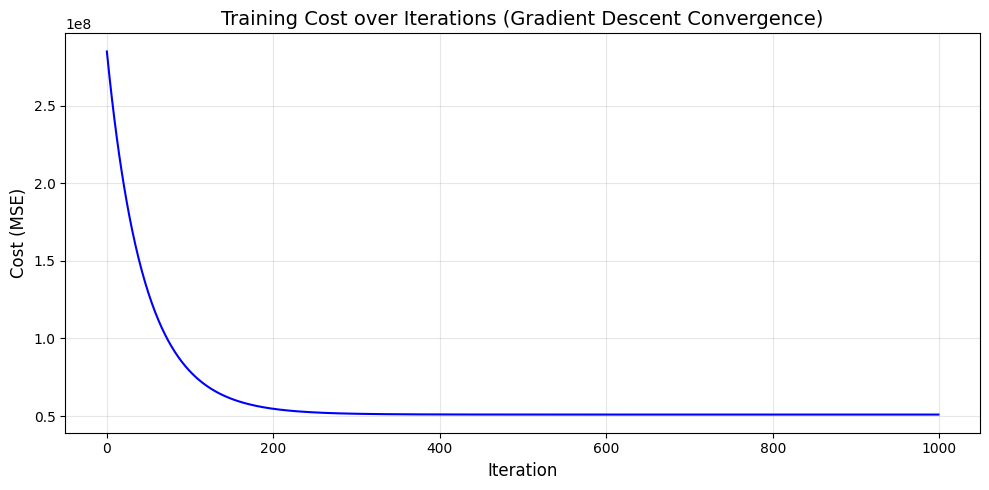

Cost curve saved to results/cost_curve.png


In [18]:
# Create a figure with a specifi size (width, height in inches)
plt.figure(figsize=(10,5))

# Plot the cost history
# cost_history is the list of cost values, one per iteration
plt.plot(cost_history, color='blue', linewidth=1.5)

# Add labels and title for clarity
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost (MSE)', fontsize=12)
plt.title('Training Cost over Iterations (Gradient Descent Convergence)', fontsize=14)

# Add grid lines to make it easier to read values
plt.grid(True, alpha=0.3)

# Use scientific notation for y-axis since costs are large numbers
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Ensure layout fits nicely
plt.tight_layout()

# Save the figure to the results folder
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

# Save the PNG with high resolution (dpi = dots per inch)
plt.savefig(os.path.join(results_dir, 'cost_curve.png'), dpi=150)

# Display the plot in the notebook
plt.show()

print(f"Cost curve saved to {results_dir}/cost_curve.png")

# Visualization 2: Predicted VS Actual Prices

- A Scatter plot of predicted vs actual values shows prediction quality.
- Perfect predictions would fall exactly on the diagonal line y=x.
- Spread around the line indicates prediction error.

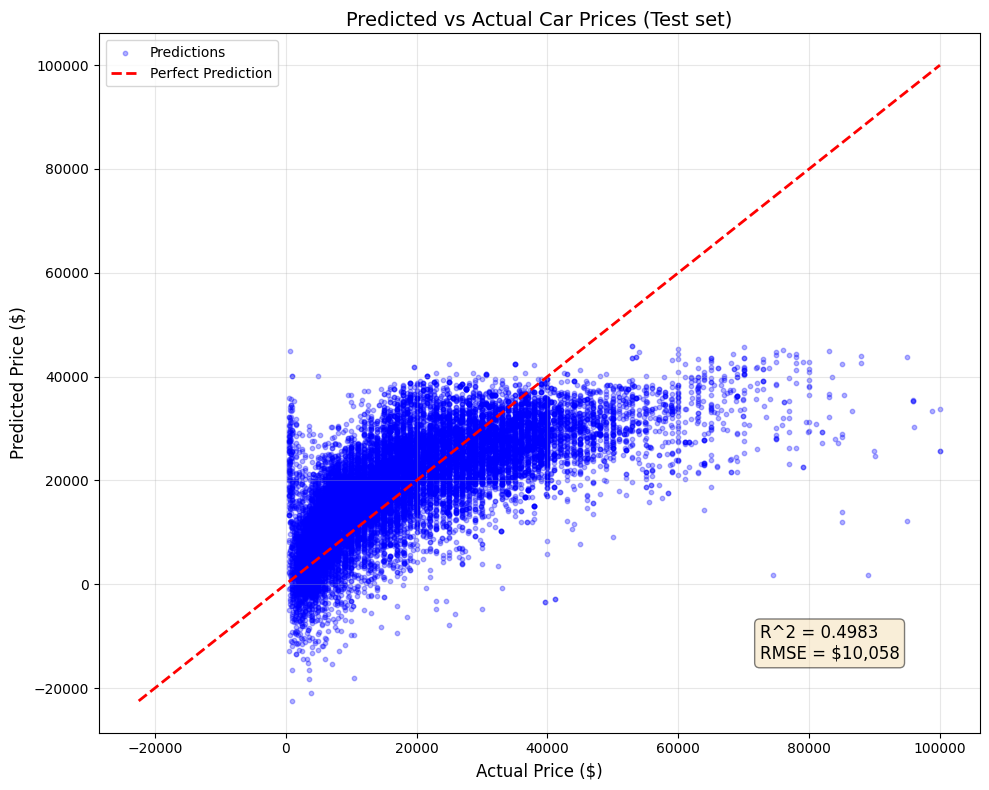

Predictions plot saved to results/predictions_vs_actual.png


In [19]:
# Create figure
plt.figure(figsize=(10, 8))

# Create scatter plot of actual vs predicted prices (test set)
# alpha controls transparency (0=invisible, 1=solid)
# s controls point size
# Using test set because it's unseen data (more honest evaluation)
plt.scatter(y_test, y_test_pred, alpha=0.3, s=10, color='blue', label='Predictions')

# Add the perfect prediction line (y = x)
# If predictions were perfect, all points would be on this line
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

# Labels and title
plt.xlabel('Actual Price ($)', fontsize=12)
plt.ylabel('Predicted Price ($)', fontsize=12)
plt.title('Predicted vs Actual Car Prices (Test set)', fontsize=14)

# Add legen to explain the lines
plt.legend(loc='upper left', fontsize=10)

# Add grid for readability
plt.grid(True, alpha=0.3)

# Add R^2 annotation on the plot
plt.annotate(f'R^2 = {test_r2:.4f}\nRMSE = ${test_rmse:,.0f}',
             xy=(0.75, 0.10), xycoords='axes fraction',
             fontsize=12, verticalalignment='bottom',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
             )

# Ensure layout fits
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(results_dir, 'predictions_vs_actual.png'), dpi=150)

# Display
plt.show()

print(f"Predictions plot saved to {results_dir}/predictions_vs_actual.png")
